In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Function

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import shutil
import pickle
np.random.seed(333)
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
data_dir = "/kaggle/input/chest-x-ray-classical-and-quantum-dataset/chest_xray/chest_xray/"
# data_dir2 = "../input/chest-xray-pneumonia/chest_xray/val/"
# data_dir3 = "../input/chest-xray-pneumonia/chest_xray/test/"
# Define transforms for the training and validation sets
data_transforms ={
    "train_transforms": transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()]),
    "valid_transforms": transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()]), 
    "test_transforms": transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
}

# Split the dataset into train, validation and test
train_data_p = 0.7
valid_data_p = 0.1
test_data_p = 0.2



In [3]:
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])#loading dataset
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

# Obtain training indices that will be used for validation and test
num_train = len(train_data)
print(len(train_data),len(valid_data),len(test_data))
indices = list(range(num_train))
np.random.shuffle(indices)
train_count = int(train_data_p*num_train)
valid_count = int(valid_data_p*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define the dataloaders using the image datasets. Dataloader is used to load our data in batches
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 1, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 1, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 1, sampler = test_sampler)
print(len(trainloader),len(validloader),len(testloader))

classes=['normal','pneumonia']

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image type to numpy image type for visualization


#Visualize some sample data
#Obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
images = images.numpy() #convert images to numpy for display

#Plot the images in the batch, along with corresponding labels


5856 5856 5856
4099 585 1172
Training 4099 0.6999658469945356
Validation 585 0.09989754098360656
Test 1172 0.20013661202185792
4099 585 1172


In [4]:
'''
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(str(labels[idx].item()))
    ax.set_title(classes[labels[idx]])
'''

'\nfig = plt.figure(figsize=(25,4))\nfor idx in np.arange(20):\n    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])\n    imshow(images[idx])\n    #ax.set_title(str(labels[idx].item()))\n    ax.set_title(classes[labels[idx]])\n'

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(59536, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = nn.Sigmoid()
        #self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


    
class Net1(nn.Module):
    def __init__(self, num_classes=2):
        super(Net1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.4)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*64*64, num_classes)
        # self.softmax = nn.Softmax(dim=1)
        self.fc2 = nn.Linear(num_classes, 1)
        self.hybrid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        
        x = self.fc(x)
        # x = self.softmax(x)
        # return x
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)
        

In [6]:
model = Net1()
optimizer_transfer = optim.Adam(model.parameters(), lr=0.001)
criterion_transfer = nn.NLLLoss()
# criterion_transfer = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

In [7]:
# Specify loss function and optimizer
#criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
    device = torch.device("cuda")
    model = model.to(device)

True


In [8]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf
    device = torch.device("cuda")

    for epoch in range(1, n_epochs+1):
        total_loss = []
        # In the training loop, I track down the loss
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        model = model.cuda()

        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # 1st step: Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()

            # Then, clear (zero out) the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).to(device)
            # Perform the Cross Entropy Loss. Calculate the batch loss.
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
            total_loss.append(loss.item())
        loss_list.append(sum(total_loss)/len(total_loss))

        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).to(device)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))

        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f}{:.4f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            loss_list[-1],
            valid_loss))

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), os.path.join('model_transfer.pt'))
            valid_loss_min = valid_loss

    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(4, loaders_transfer, model, optimizer_transfer, criterion_transfer, use_cuda, os.path.join('model_transfer.pt'))


# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(os.path.join('model_transfer.pt')))



Epoch: 1 	Training Loss: -0.72976-0.7298 	Validation Loss: -0.74355
Validation loss decreased (inf --> -0.74355). Saving model ...
Epoch: 2 	Training Loss: -0.73018-0.7302 	Validation Loss: -0.74352
Epoch: 3 	Training Loss: -0.73018-0.7302 	Validation Loss: -0.74191
Epoch: 4 	Training Loss: -0.73018-0.7302 	Validation Loss: -0.74190


<All keys matched successfully>

Text(0, 0.5, 'Neg Log Likelihood Loss')

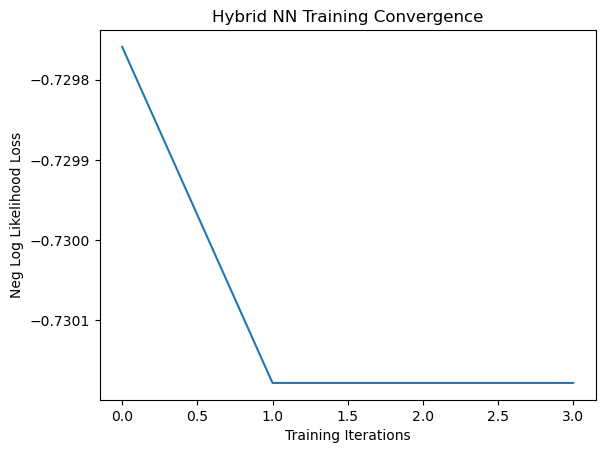

In [9]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    device = torch.device("cuda")

    model_transfer.eval() #set model into evaluation/testing mode. It turns of drop off layer
    with torch.no_grad():
        #Iterating over test data
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).to(device)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to 
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


#Obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.__next__()
images.numpy

#Move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

#Get sample outputs
output= model_transfer(images)

#Convert output probabilities to predicted class
_,preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# print(model_transfer.state_dict())

Test Loss: -0.720136


Test Accuracy: 72% (844/1172)


In [11]:


nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(loaders_transfer['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)



tensor([[  0., 327.],
        [  1., 844.]])


In [12]:
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()])
# /kaggle/input/human-non-human-classical-quantum-dataset/human and non human/human and non human/humans/AJ_Lamas_0001.jpg
image_path = "/kaggle/input/chest-x-ray-classical-and-quantum-dataset/chest_xray/chest_xray/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(image_path)
img = img.convert('RGB')
batch_t = torch.unsqueeze(transform(img), 0)
device = torch.device("cuda")
batch_t = batch_t.to(device)

model.eval()
outputs = model(batch_t)
_, predicted = torch.max(outputs, 1)
title = [['normal','pneumonia'][x] for x in predicted]
#prob = torch.nn.functional.softmax(1, dim=1)[0] * 100
print(outputs,predicted,title)

tensor([[0., 1.]], device='cuda:0', grad_fn=<CatBackward0>) tensor([1], device='cuda:0') ['pneumonia']
